In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from intent_classification_helper import *

In [7]:
f = open('/content/drive/MyDrive/nlp_datasets/CLINC150/clinc150_uci/data_full.json')
data = json.load(f)

train_df = pd.DataFrame.from_dict(data['train'])
train_df.columns = ['message', 'intent']

val_df = pd.DataFrame.from_dict(data['val'])
val_df.columns = ['message', 'intent']

test_df = pd.DataFrame.from_dict(data['test'])
test_df.columns = ['message', 'intent']

print('number of intent classes in training set: ', len(set(train_df['intent'])))
print('number of intent classes in val set: ', len(set(val_df['intent'])))
print('number of intent classes in test set: ', len(set(test_df['intent'])))

number of intent classes in training set:  150
number of intent classes in val set:  150
number of intent classes in test set:  150


In [8]:
# preprocess text
print('Preprocessing text on training set...')
preprocess_text(train_df, 'message')

print('Preprocessing text on val set...')
preprocess_text(val_df, 'message')

print('Preprocessing text on test set...')
preprocess_text(test_df, 'message')

Preprocessing text on training set...


Start text preprocessing: 
--------------------------
Converting to lowercase...
--------------------------
Removing html tags...
--------------------------
Removing nonword characters...
--------------------------
Removing stopwords...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text preprocessing completed.


Preprocessing text on val set...


Start text preprocessing: 
--------------------------
Converting to lowercase...
--------------------------
Removing html tags...
--------------------------
Removing nonword characters...
--------------------------
Removing stopwords...
Text preprocessing completed.


Preprocessing text on test set...


Start text preprocessing: 
--------------------------
Converting to lowercase...
--------------------------
Removing html tags...
--------------------------
Removing nonword characters...
--------------------------
Removing stopwords...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text preprocessing completed.




In [11]:
y_train = train_df['intent'].tolist()
y_test = test_df['intent'].tolist()

In [ ]:
# the below sections of code is used to find k-means label mapping, there is an issue of duplicate mapping that needs to be revisited

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tv = TfidfVectorizer(max_df=1.0, min_df=0)
    
x_train = train_df['message'].tolist()
x_test = test_df['message'].tolist()

tv.fit(x_train)
x_train = tv.transform(x_train).toarray()
x_test = tv.transform(x_test).toarray()

vocab = tv.get_feature_names_out()

print('TF-IDF vocabulary size: ', len(vocab))

num_classes = 150
kmeans = KMeans(n_clusters=num_classes, random_state=8)
kmeans.fit(x_train)

TF-IDF vocabulary size:  4901


KMeans(n_clusters=150, random_state=8)

In [14]:
label_map = {}

for i in range(len(y_train)):
  key = '{} {}'.format(kmeans.labels_[i], y_train[i])
  if key in label_map:
    label_map[key] += 1
  else:
    label_map[key] = 1

In [31]:
lst = sorted(label_map.items())

curr_label = ''
max_times = 0
kmeans_label_map = {}

for item in lst:
  if item[0].split()[0] != curr_label:
    curr_label = item[0].split()[0]
    max_times = 0
  if item[1] > max_times:
    max_times = item[1]
    kmeans_label_map[int(curr_label)] = item[0].split()[1]

In [ ]:
kmeans_label_map

In [33]:
flipped = {}

for key, value in kmeans_label_map.items():
  if value in flipped:
    flipped[value].append(key) 
  else:
    flipped[value] = [key]

In [ ]:
flipped

In [37]:
def kmeans_tf_idf(feature_numbers=[40, 100, 200, 500, 1000, 2000, 3000, 4000, 5000]):
  
  # try different number of features
  for feature_number in feature_numbers:  
    tv = TfidfVectorizer(max_df=1.0, min_df=0, max_features=feature_number)
    
    x_train = train_df['message'].to_list()
    x_test = test_df['message'].to_list()

    tv.fit(x_train)
    x_train = tv.transform(x_train).toarray()
    x_test = tv.transform(x_test).toarray()

    vocab = tv.get_feature_names_out()

    print('TF-IDF vocabulary size: ', len(vocab))
    #print(pd.DataFrame(x_train, columns=vocab))
    
    num_classes = 150
    kmeans = KMeans(n_clusters=num_classes, random_state=8)
    kmeans.fit(x_train)

    y_true = y_test
    prediction = kmeans.predict(x_test)
    mapped_prediction = []

    for i in range(len(prediction)):
      mapped_prediction.append(kmeans_label_map[prediction[i]])

    prediction = mapped_prediction

    evaluate_model(model=None, name='kmeans_tf-idf_{}'.format(len(vocab)), x_test=x_test, y_test=y_test, num_features=len(vocab), path='/content/drive/MyDrive/nlp_datasets/CLINC150/models',
                   filename='evaluation_kmeans.csv', unsupervised=True, prediction=prediction)
    
    print()
    if feature_number < len(vocab):
      break

In [38]:
kmeans_tf_idf()

TF-IDF vocabulary size:  40
evaluate the model:  kmeans_tf-idf_40


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy score:  0.0024444444444444444
balanced accuracy score:  0.002444444444444445
weighted precision:  0.0010681554012485755
weighted recall:  0.0024444444444444444
weighted f1 score:  0.0013697125524219694
macro f1 score:  0.0013697125524219692

TF-IDF vocabulary size:  100
evaluate the model:  kmeans_tf-idf_100
accuracy score:  0.013555555555555555
balanced accuracy score:  0.013555555555555555
weighted precision:  0.011146107641928076
weighted recall:  0.013555555555555555
weighted f1 score:  0.01112310257310279
macro f1 score:  0.01112310257310279


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.





TF-IDF vocabulary size:  200
evaluate the model:  kmeans_tf-idf_200
accuracy score:  0.002
balanced accuracy score:  0.0020000000000000005
weighted precision:  0.0034245515956207776
weighted recall:  0.002
weighted f1 score:  0.002047582141431222
macro f1 score:  0.002047582141431222



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




TF-IDF vocabulary size:  500
evaluate the model:  kmeans_tf-idf_500
accuracy score:  0.01711111111111111
balanced accuracy score:  0.01711111111111111
weighted precision:  0.016453204847422978
weighted recall:  0.01711111111111111
weighted f1 score:  0.01563734187371577
macro f1 score:  0.01563734187371577



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




TF-IDF vocabulary size:  1000
evaluate the model:  kmeans_tf-idf_1000
accuracy score:  0.0008888888888888889
balanced accuracy score:  0.0008888888888888888
weighted precision:  0.0006819956968294564
weighted recall:  0.0008888888888888889
weighted f1 score:  0.0007284696854700295
macro f1 score:  0.0007284696854700294



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




TF-IDF vocabulary size:  2000
evaluate the model:  kmeans_tf-idf_2000
accuracy score:  0.007555555555555556
balanced accuracy score:  0.007555555555555555
weighted precision:  0.006171507927941731
weighted recall:  0.007555555555555556
weighted f1 score:  0.006507683212652525
macro f1 score:  0.006507683212652526



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




TF-IDF vocabulary size:  3000
evaluate the model:  kmeans_tf-idf_3000
accuracy score:  0.010222222222222223
balanced accuracy score:  0.010222222222222221
weighted precision:  0.008506154332682692
weighted recall:  0.010222222222222223
weighted f1 score:  0.008244143041755156
macro f1 score:  0.008244143041755156



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




TF-IDF vocabulary size:  4000
evaluate the model:  kmeans_tf-idf_4000
accuracy score:  0.008222222222222223
balanced accuracy score:  0.008222222222222221
weighted precision:  0.0021713660835359187
weighted recall:  0.008222222222222223
weighted f1 score:  0.0026652628936435006
macro f1 score:  0.0026652628936435006



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




TF-IDF vocabulary size:  4901
evaluate the model:  kmeans_tf-idf_4901
accuracy score:  0.4568888888888889
balanced accuracy score:  0.4568888888888889
weighted precision:  0.5021075182083271
weighted recall:  0.4568888888888889
weighted f1 score:  0.4475438001477565
macro f1 score:  0.4475438001477564



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


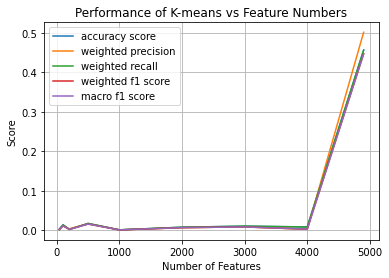

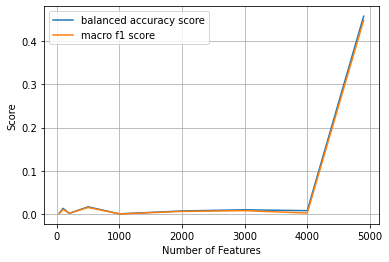

In [39]:
# plot the feature importance graph for random forest
plt.title('Performance of K-means vs Feature Numbers')
plt.xlabel('Number of Features')
plt.ylabel('Score')

eval_path = '/content/drive/MyDrive/nlp_datasets/CLINC150/models/evaluation_kmeans.csv'
eval_result = pd.read_csv(eval_path, error_bad_lines=False, engine='python', encoding='utf-8')

feature_numbers = eval_result['num_features'].to_list()
accuracy_scores = eval_result['accuracy score'].to_list()
balanced_accuracy_scores = eval_result['balanced accuracy score'].to_list()
weighted_precision = eval_result['weighted precision'].to_list()
weighted_recall = eval_result['weighted recall'].to_list()
weighted_f1_scores = eval_result['weighted f1 score'].to_list()
macro_f1_scores = eval_result['macro f1 score'].to_list()

plt.plot(feature_numbers, accuracy_scores, label='accuracy score')
plt.plot(feature_numbers, weighted_precision, label='weighted precision')
plt.plot(feature_numbers, weighted_recall, label='weighted recall')
plt.plot(feature_numbers, weighted_f1_scores, label='weighted f1 score')
plt.plot(feature_numbers, macro_f1_scores, label='macro f1 score')
plt.legend()
plt.grid()

plt.figure()
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.plot(feature_numbers, balanced_accuracy_scores, label='balanced accuracy score')
plt.plot(feature_numbers, macro_f1_scores, label='macro f1 score')

plt.legend()
plt.grid()
plt.show()